# 3. Beamforming for location

This notebook computes the beamformed network response and demonstrates how to use it for the detection and location of an eathquake. The workflow consists of computing waveform features first (envelopes, kurtosis, etc.) and, then, to shift-and-stack them according to the previously computed travel times.

## Contents

* [Compute waveform features](#compute-waveform-features)

* [Read travel times](#read-travel-times)

* [Show an example waveform](#show-an-example-envelope)

In [336]:
import beampower as bp
import glob
import h5py as h5
import numpy as np
import os
import pandas as pd
import tqdm

from matplotlib import pyplot as plt
from scipy import signal, stats
from obspy import read, read_inventory, UTCDateTime
from obspy.geodetics.base import locations2degrees, degrees2kilometers
try:
    from scipy.stats import median_abs_deviation as scimad
except ImportError:
    from scipy.stats import median_absolute_deviation as scimad

In [337]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Compute waveform features

The underlying paradigm of the beamforming method is that when using the exact travel times to align the traces, they sum up to the largest amplitude beam. However, the waves emitted by a double-couple source may sum up to zero due to antisymmetries in the radiated wavefield. Furthermore, imprecisions in the velocity model and the finiteness of the grid often mean that the exact travel times are not available in the pre-computed travel time grid.


To address the aforementionned drawbacks, we compute positive-valued *waveform features* to handle antisymmetries in the wavefield and we make sure that they are smooth enough in time to be correctly aligned by at least one set of pre-computed travel times (think of trying, unsuccesfully, to align Diracs with a finite resolution travel time grid!).

Here, we use the waveform envelopes. The envelope is computed from the analytical signal (Hilbert transform). To avoid noisy stations from dominating the beams, we normalize each trace by its median absolute deviation. The envelopes are clipped above $10^5$ times the mean absolute deviation in order to avoid spikes or proximal transient noise to corrupt the beams.

In [338]:
def envelope(x):
    """Envelope transformation.

    Calculate the envelope of the input one-dimensional signal with the Hilbert
    transform. The data is normalized by the mean absolute deviation over the
    entire signal window first. The envelope is clipped at a maximum of 10^5
    times the mad of the envelope.
    
    Arguments
    ---------
    x: array-like
        The input one-dimensional signal.
    
    Returns
    -------
    array-like
        The envelope of x with same shape than x.
    """

    # Envelope
    x = np.abs(signal.hilbert(x))
    
    # Normalization
    x_mad = scimad(x)
    x_mad = 1.0 if x_mad == 0.0 else x_mad
    x = (x - np.median(x)) / x_mad
    
    # Clip
    x_max = 10.0 ** 5.0
    return x.clip(None, x_max)

Read the network metadata into the `network` `pandas.DataFrame`. We will use `network` and its list of stations to order consistently the `waveform_features` and `travel_times` arrays.

In [339]:
NETWORK_PATH = "../data/network.csv"
network = pd.read_csv(NETWORK_PATH)
network

,code,longitude,latitude,elevation,depth
0,DC06,30.265751,40.616718,555.0,-0.555
1,DC07,30.242170,40.667080,164.0,-0.164
2,DC08,30.250130,40.744438,162.0,-0.162
3,DD06,30.317770,40.623539,182.0,-0.182
4,DE07,30.411539,40.679661,40.0,-0.040
5,DE08,30.406469,40.748562,31.0,-0.031
6,SAUV,30.327200,40.740200,170.0,-0.170
7,SPNC,30.308300,40.686001,190.0,-0.190


We first initialize the waveform features as a `DataArray` in order to keep explicit indexing.

In [340]:
DIRPATH_INVENTORY = "../data/processed/*.xml"
DIRPATH_WAVEFORMS = "../data/processed/*.mseed"
COMPONENTS = ["N", "E", "Z"]
num_stations = len(network)
num_components = len(COMPONENTS)

# Find the miniseed files and read them with obspy's read function
filepaths_waveforms = glob.glob(DIRPATH_WAVEFORMS)
traces = read(DIRPATH_WAVEFORMS)

# set the num_samples variables to 1 day (some traces may have num_samples+1 samples because of
# time rounding errors when downloading and preprocessing the data)
num_samples = int(24. * 3600. * traces[0].stats.sampling_rate)

waveform_features = np.zeros(
    (num_stations, num_components, num_samples), dtype=np.float32
)
for s, sta in enumerate(network.code):
    for c, cp in enumerate(COMPONENTS):
        tr = traces.select(station=sta, component=cp)[0]
        waveform_features[s, c, :] = envelope(tr.data)[..., :num_samples]

## Show an example envelope

Example of a waveform with corresponding envelope.

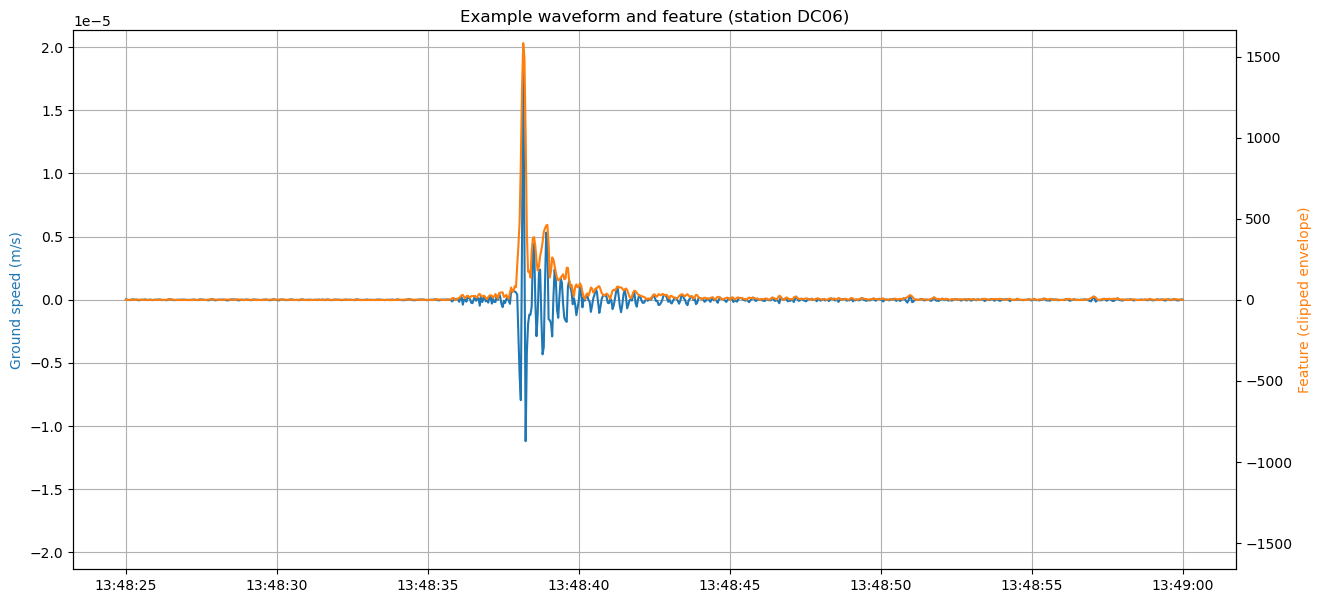

In [341]:
START, END = "2012-07-26 13:48:25", "2012-07-26 13:49:00"
STATION_NAME = "DC06"
# STATION_NAME = network.code.iloc[2]
COMPONENT = "E"

station_idx = network.code.values.tolist().index(STATION_NAME)
component_idx = COMPONENTS.index(COMPONENT)

# Get example waveform
trace = traces.select(station=STATION_NAME, component=COMPONENT)[0]
starttime_idx = int((UTCDateTime(START) - trace.stats.starttime) / trace.stats.delta)
trace = trace.slice(starttime=UTCDateTime(START), endtime=UTCDateTime(END))
endtime_idx = starttime_idx + len(trace.data)
times = pd.to_datetime(trace.times("timestamp"), unit="s")

# Plot waveform
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(times, trace.data)
ymax = max(np.abs(ax.get_ylim()))
ax.set_ylim(-ymax, ymax)
ax.set_ylabel("Ground speed (m/s)", color="C0")
ax.set_title(f"Example waveform and feature (station {STATION_NAME})")
ax.grid()

# Plot envelope on a second axe (not the same scale)
ax = ax.twinx()
ax.plot(times, waveform_features[station_idx, component_idx, starttime_idx:endtime_idx], color="C1")

# Labels
ax.set_ylabel("Feature (clipped envelope)", color="C1")
ax.set_ylim(bottom=-max(ax.get_ylim()))
ax.set_title("")
plt.show()

## Initialize beamforming

### Load travel times and convert them to samples

Get the travel times obtained from [our notebook #2](2_travel_times.ipynb) on travel time computation.

In [342]:
# load grid point coordinates and travel times as a numpy array
PHASES = ["P", "S"]
travel_times = []
source_coordinates = {}
with h5.File("../data/travel_times.h5", mode="r") as ftt:
    for field in ftt["source_coordinates"]:
        source_coordinates[field] = ftt["source_coordinates"][field][()].flatten()
    num_sources = len(source_coordinates[field])
    travel_times = np.zeros((num_sources, num_stations, len(PHASES)), dtype=np.float32)
    for p, phase in enumerate(PHASES):
        for s, sta in enumerate(network.code):
            travel_times[:, s, p] = ftt[phase][sta][()].flatten()

In [343]:
# convert travel times in seconds to time delays in samples
def sec_to_samp(t, sr, epsilon=0.2):
    """Convert seconds to samples taking into account rounding errors.

    Parameters
    -----------
    """
    # we add epsilon so that we fall onto the right
    # integer number even if there is a small precision
    # error in the floating point number
    sign = np.sign(t)
    t_samp_float = abs(t * sr) + epsilon
    # round and restore sign
    t_samp_int = np.int32(sign * np.int32(t_samp_float))
    return t_samp_int

sampling_rate = traces[0].stats.sampling_rate
time_delays = sec_to_samp(travel_times, sampling_rate)
# you may uncomment the following line to make the time delays relative to the first P-wave arrival for each source
# time_delays -= np.min(time_delays, axis=(1, 2), keepdims=True)

### Define the phase-specific weights

We recall that the general definition of a beam, with source-receiver $\beta_{k, s}$ and phase-specific weights $\alpha_{s, c, p}$, is:
$$ b_k(t) = \sum_{s, c, p} \beta_{k, s} \alpha_{s, c, p} \mathcal{U}_{s, c}(t + \tau_{s, p}^{(k)}),$$
where $k$ is the source (grid point) index, $\mathcal{U}_{s, c}(t)$ is the waveform feature at station $s$, channel $c$ and time $t$, and $\tau_{s, p}^{(k)}$ is the moveout at station $s$, seismic phase $p$ and source $k$. For a given $p$, the moveout is the same at all channels of the same station $s$. Therefore, the quantity $U_{s, p}(t) = \sum_{c} \alpha_{s, c, p} \mathcal{U}_{s, c}(t)$ can be computed once and for all instead of re-computing it for each source.

$\alpha_{s, c, p}$ is the phase-specific weight at station $s$ and channel $c$ and for phase $p$. In this tutorial, $\mathcal{U}_{s, c}$ is the envelope of the trace at station $s$ and channel $c$. We define $\alpha_{s, c, p}$ so that horizontal-component traces contribute to the S-wave beam and vertical-component traces contribute to the P-wave beam. 

$$ \alpha_{s, c=0, p=0} = 0;\quad \alpha_{s, c=1, p=0} = 0;\quad \alpha_{s, c=2, p=0} = 1$$
$$ \alpha_{s, c=0, p=1} = 1;\quad \alpha_{s, c=1, p=1} = 1;\quad \alpha_{s, c=2, p=1} = 0.$$

In [344]:
# Phase weights
weights_phase = np.zeros((num_stations, num_components, len(PHASES)), dtype=np.float32)
weights_phase[:, :2, 0] = 0. # horizontal component traces do not contribute to P-wave beam
weights_phase[:, 2, 0] = 1. # vertical component traces contribute to P-wave beam
weights_phase[:, :2, 1] = 1. # horizontal component traces contribute to S-wave beam
weights_phase[:, 2, 1] = 0. # vertical component traces do not contribute to S-wave beam

## Define the source-receiver weights

When using a grid covering a large geographical region, all stations may not be relevant to every source (grid point). Small earthquakes occurring at one end of the region are unlikely to be recorded by stations at the other end of the region. In order to only use the relevant data to each source, the source-receiver weights can be adjusted. Typically, $\beta_{k, s} = 0$ when source $k$ is further than XXkm from station $s$. In this tutorial, we deal with a relatively small-scale problem so we keep all weights equal to 1.

In [345]:
# Sources weights
weights_sources = np.ones(time_delays.shape[:-1], dtype=np.float32)

## Compute the beamformed network response

At each time step, we compute the beamformed network response for every grid point and keep the maximum. We thus obtain a time series of maximum beams at every time.

In [346]:
beam_max, beam_argmax = bp.beamform(
    waveform_features,
    time_delays,
    weights_phase,
    weights_sources,
    device="cpu",
    reduce="max",
)

## Detect

We detect the maxima with find peaks and use a threshold criterion to keep only the prominent peaks (or events).

### Designing the detection threshold

The detection threshold is a crucial step in turning the maximum beam into an earthquake detector. In this minimalistic example with envelope-based backprojection, the maximum beam is extremely noisy and the detection threshold needs to adapt, as much as possible, to noise variations. In the following, we show how to efficiently compute a time-dependent detection threshold. 

In [347]:
def time_dependent_threshold(
    time_series, sliding_window, overlap=0.66, threshold_type="rms", num_dev=8.
):
    """
    Time dependent detection threshold.

    Parameters
    -----------
    time_series: (n_correlations) array_like
        The array of correlation coefficients calculated by
        FMF (float 32).
    sliding_window: scalar integer
        The size of the sliding window, in samples, used
        to calculate the time dependent central tendency
        and deviation of the time series.
    overlap: scalar float, default to 0.66
    threshold_type: string, default to 'rms'
        Either rms or mad, depending on which measure
        of deviation you want to use.

    Returns
    ----------
    threshold: (n_correlations) array_like
        Returns the time dependent threshold, with same
        size as the input time series.
    """
    
    time_series = time_series.copy()
    threshold_type = threshold_type.lower()
    n_samples = len(time_series)
    half_window = sliding_window // 2
    shift = int((1.0 - overlap) * sliding_window)
    zeros = time_series == 0.0
    n_zeros = np.sum(zeros)
    white_noise = np.random.normal(size=n_zeros).astype("float32")
    if threshold_type == "rms":
        default_center = time_series[~zeros].mean()
        default_deviation = np.std(time_series[~zeros])
        # note: white_noise[n_zeros] is necessary in case white_noise
        # was not None
        time_series[zeros] = (
                white_noise[:n_zeros] * default_deviation + default_center
        )
        time_series_win = np.lib.stride_tricks.sliding_window_view(
            time_series, sliding_window
        )[::shift, :]
        center = np.mean(time_series_win, axis=-1)
        deviation = np.std(time_series_win, axis=-1)
    elif threshold_type == "mad":
        default_center = np.median(time_series[~zeros])
        default_deviation = np.median(np.abs(time_series[~zeros] - default_center))
        time_series[zeros] = (
                white_noise[:n_zeros] * default_deviation + default_center
        )
        time_series_win = np.lib.stride_tricks.sliding_window_view(
            time_series, sliding_window
        )[::shift, :]
        center = np.median(time_series_win, axis=-1)
        deviation = np.median(
            np.abs(time_series_win - center[:, np.newaxis]), axis=-1
        )
    threshold = center + num_dev * deviation
    threshold[1:] = np.maximum(threshold[:-1], threshold[1:])
    threshold[:-1] = np.maximum(threshold[:-1], threshold[1:])
    time = np.arange(half_window, n_samples - (sliding_window - half_window))
    indexes_l = time // shift
    indexes_l[indexes_l >= len(threshold)] = len(threshold) - 1
    threshold = threshold[indexes_l]
    threshold = np.hstack(
        (
            threshold[0] * np.ones(half_window, dtype=np.float32),
            threshold,
            threshold[-1] * np.ones(sliding_window - half_window, dtype=np.float32),
        )
    )
    return threshold


In [348]:
# the detection threshold is evaluated in a sliding window with duration SLIDING_WINDOW_DURATION_SEC
SLIDING_WINDOW_DURATION_SEC = 7200.
# within each sliding window, the detection threshold is the mean (median) + NUM_DEV the standard deviation (median absolute deviation)
NUM_DEV = 8.

# compute the time-dependent detection threshold
window_length = int(SLIDING_WINDOW_DURATION_SEC * sampling_rate)
threshold = time_dependent_threshold(beam_max, window_length, num_dev=NUM_DEV, threshold_type="rms")

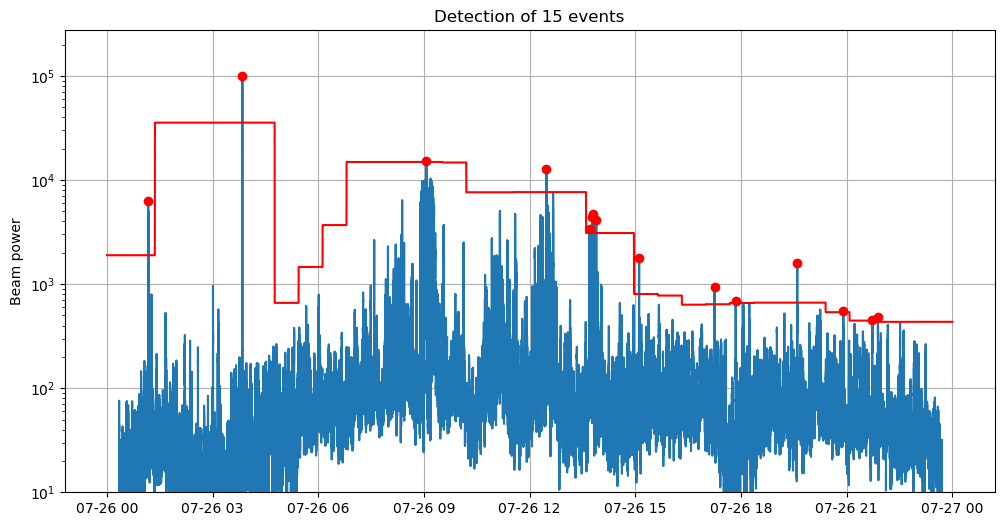

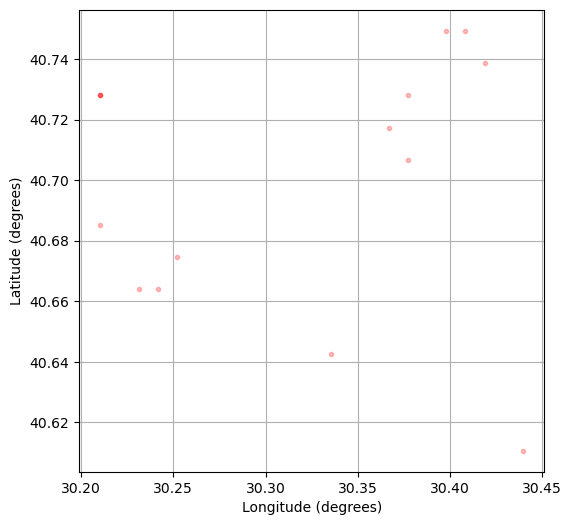

In [349]:
MIN_DETECTION_INTERVAL = int(60 * sampling_rate)

# Detect
peaks, peak_properties = signal.find_peaks(beam_max, distance=MIN_DETECTION_INTERVAL)
# scipy's find_peaks function has a lot of interesting parameters you can play with. For example,
# the "prominence" parameter may help discard flat peaks that are typical of when a single station
# dominates a beam
# peaks, peak_properties = signal.find_peaks(beam_max, distance=MIN_DETECTION_INTERVAL, prominence=50, wlen=int(1. * sampling_rate))
peaks = peaks[beam_max[peaks] > threshold[peaks]]

# Show
fig_beam = plt.figure("beam", figsize=(12, 6))

times = pd.to_datetime(traces[0].times("timestamp")[:num_samples], unit="s").copy()

plt.plot(times, beam_max)
plt.plot(times, threshold, color="r")
plt.plot(times[peaks], beam_max[peaks], marker="o", ls="", color="r", label="Detections")

plt.semilogy()
plt.ylim(bottom=10)
plt.ylabel("Beam power")
plt.grid()
plt.title(f"Detection of {len(peaks)} events")
plt.show()

fig_events = plt.figure("epicenters", figsize=(6, 6))
plt.plot(source_coordinates["longitude"][beam_argmax[peaks]], source_coordinates["latitude"][beam_argmax[peaks]], ".r", alpha=0.25)
plt.xlabel("Longitude (degrees)")
plt.ylabel("Latitude (degrees)")
plt.grid()

## Show detection

We detect the maxima with find peaks and use a threshold criterion to keep only the prominent peaks (or events).

### Plot with waveforms

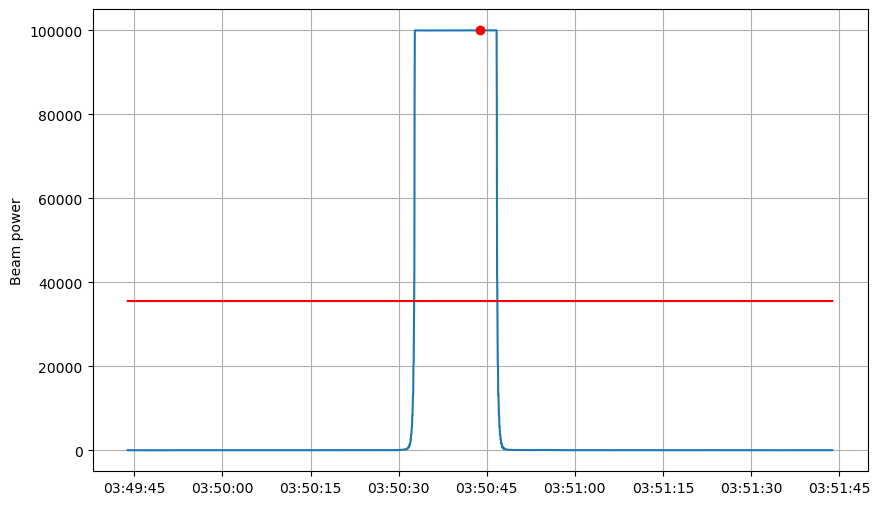

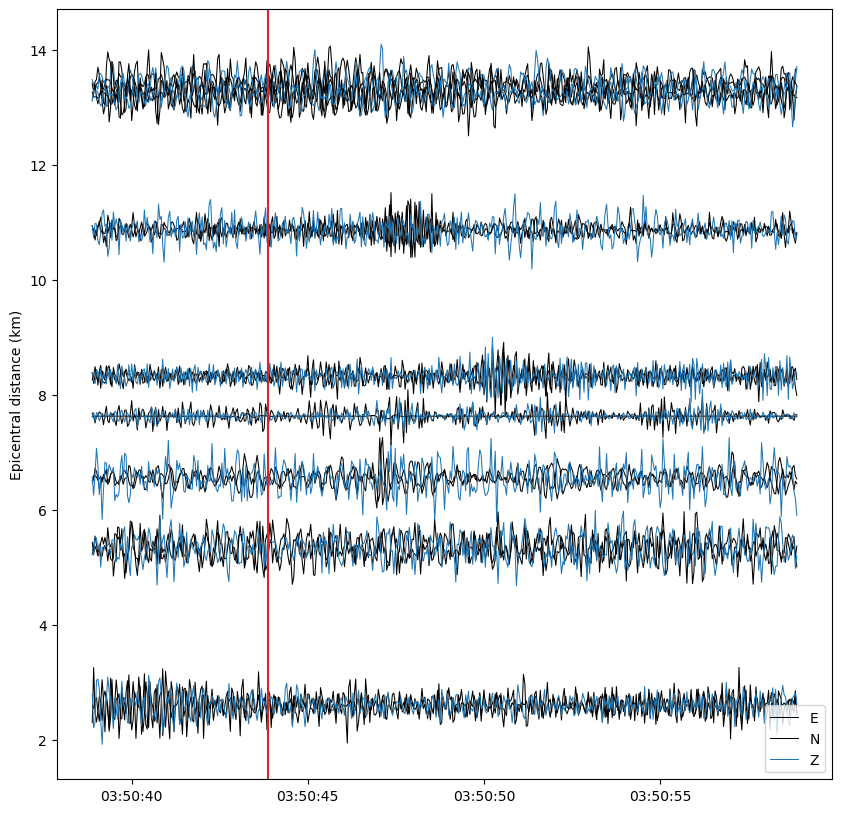

In [350]:
COLORS = {"E": "k", "N": "k", "Z": "C0"}

def scale_amplitude(x, scale_factor=1.0):
    x_norm = np.max(np.abs(x))
    x_norm = 1 if x_norm == 0. else x_norm
    x_log_norm = np.log10(x_norm)
    return x * x_log_norm * scale_factor / x_norm
    

# START, END = "2012-07-26 13:48:00", "2012-07-26 13:50:00"
BUFFER_BEFORE_SAMPLES = int(60. * sampling_rate)
BUFFER_AFTER_SAMPLES = int(60. * sampling_rate)

peak_to_watch = peaks[7]
# peak_to_watch = peaks[8]
peak_to_watch = peaks[1]

starttime_idx = peak_to_watch - BUFFER_BEFORE_SAMPLES
endtime_idx = peak_to_watch + BUFFER_AFTER_SAMPLES
slice_ = np.s_[starttime_idx:endtime_idx]

peaks_in_zoom = peaks[
    (peaks >= starttime_idx) & (peaks <= endtime_idx)
]

inventory = read_inventory(DIRPATH_INVENTORY)


# Show
fig = plt.figure(figsize=(10, 6))
plt.plot(times[slice_], beam_max[slice_])
plt.plot(times[slice_], threshold[slice_], color="r")
plt.plot(times[peaks_in_zoom], beam_max[peaks_in_zoom], marker="o", ls="", color="r")
# plt.semilogy()
plt.grid()
plt.ylabel("Beam power")

# Watch peak
date = UTCDateTime(str(times[peak_to_watch]))
lon = source_coordinates["longitude"][beam_argmax[peak_to_watch]]
lat = source_coordinates["latitude"][beam_argmax[peak_to_watch]]

# Get waveform
fig, ax = plt.subplots(1, figsize=(10, 10))
for index, trace in enumerate(read(DIRPATH_WAVEFORMS)):

    # Get trace and info
    trace = trace.slice(date - 5, date + 15)        
    trace.filter(type="highpass", freq=2)
    times_tr = pd.to_datetime(trace.times("timestamp"), unit="s")
    # data = trace.data / np.abs(trace.data).max()
    data = scale_amplitude(trace.data, scale_factor=0.1)
    


    coords = inventory.get_coordinates(trace.id)
    p1 = lat, lon
    p2 = [coords[dim] for dim in ["latitude", "longitude"]]
    distance = degrees2kilometers(locations2degrees(*p1, *p2))

    # Plot trace
    ax.plot(times_tr, data + distance, color=COLORS[trace.stats.channel[-1]], lw=0.75)
 

# Labels
ax.set_ylabel("Epicentral distance (km)")
ax.axvline(date, color="C3")
ax.legend([key for key in COLORS])
    

### Plot with envelopes

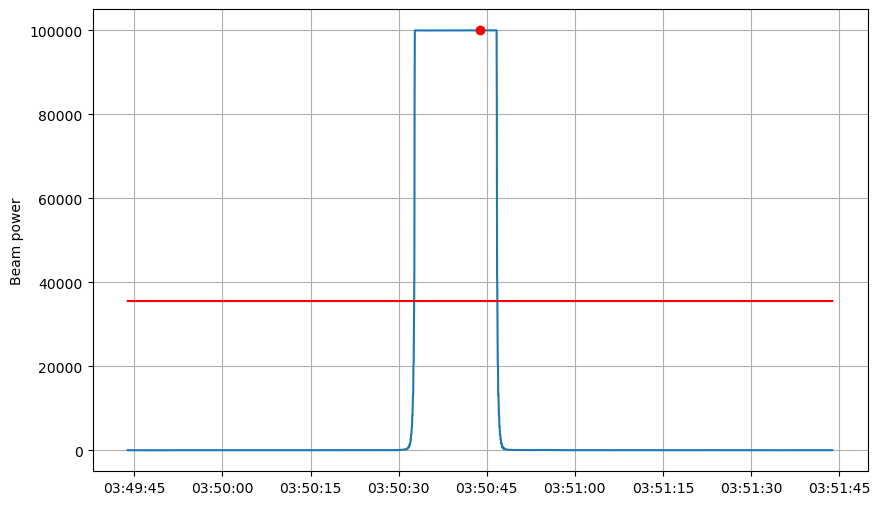

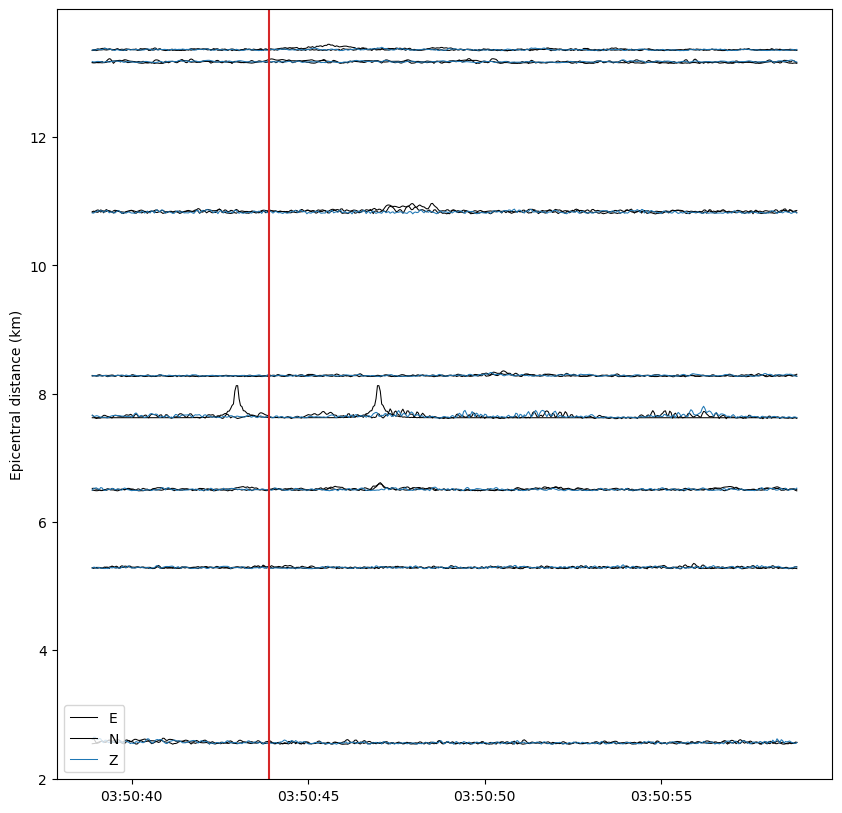

In [351]:
COLORS = {"E": "k", "N": "k", "Z": "C0"}

def scale_amplitude(x, scale_factor=1.0):
    x_norm = np.max(np.abs(x))
    x_norm = 1 if x_norm == 0. else x_norm
    x_log_norm = np.log10(x_norm)
    return x * x_log_norm * scale_factor / x_norm
    

# START, END = "2012-07-26 13:48:00", "2012-07-26 13:50:00"
BUFFER_BEFORE_SAMPLES = int(60. * sampling_rate)
BUFFER_AFTER_SAMPLES = int(60. * sampling_rate)

peak_to_watch = peaks[7]
# peak_to_watch = peaks[8]
peak_to_watch = peaks[1]

starttime_idx = peak_to_watch - BUFFER_BEFORE_SAMPLES
endtime_idx = peak_to_watch + BUFFER_AFTER_SAMPLES
slice_ = np.s_[starttime_idx:endtime_idx]

peaks_in_zoom = peaks[
    (peaks >= starttime_idx) & (peaks <= endtime_idx)
]

inventory = read_inventory(DIRPATH_INVENTORY)


# Show
fig = plt.figure(figsize=(10, 6))
plt.plot(times[slice_], beam_max[slice_])
plt.plot(times[slice_], threshold[slice_], color="r")
plt.plot(times[peaks_in_zoom], beam_max[peaks_in_zoom], marker="o", ls="", color="r")
# plt.semilogy()
plt.grid()
plt.ylabel("Beam power")

# Watch peak
date = UTCDateTime(str(times[peak_to_watch]))
lon = source_coordinates["longitude"][beam_argmax[peak_to_watch]]
lat = source_coordinates["latitude"][beam_argmax[peak_to_watch]]

    
# Plot waveform feature
fig, ax = plt.subplots(1, figsize=(10, 10))
starttime_idx = int((date - 5. - traces[0].stats.starttime) / traces[0].stats.delta)
endtime_idx = int((date + 15. - traces[0].stats.starttime) / traces[0].stats.delta)
for s in range(num_stations):
    
    p1 = lat, lon
    p2 = [network.latitude.iloc[s], network.longitude.iloc[s]]
    distance = degrees2kilometers(locations2degrees(*p1, *p2))
    
    for c, cp in enumerate(COMPONENTS):
    
        data = waveform_features[s, c, starttime_idx:endtime_idx]
        data = scale_amplitude(data + data.min(), scale_factor=0.1)
        times_tr = times[starttime_idx:endtime_idx]
        
        # Plot trace
        ax.plot(times_tr, data + distance, color=COLORS[cp], lw=0.75)
 

# Labels
ax.set_ylabel("Epicentral distance (km)")
ax.axvline(date, color="C3")
ax.legend([key for key in COLORS])
    

## Going further